# Order Delivery Time Prediction

## Objectives
The objective of this assignment is to build a regression model that predicts the delivery time for orders placed through Porter. The model will use various features such as the items ordered, the restaurant location, the order protocol, and the availability of delivery partners.

The key goals are:
- Predict the delivery time for an order based on multiple input features
- Improve delivery time predictions to optimiae operational efficiency
- Understand the key factors influencing delivery time to enhance the model's accuracy

## Data Pipeline
The data pipeline for this assignment will involve the following steps:
1. **Data Loading**
2. **Data Preprocessing and Feature Engineering**
3. **Exploratory Data Analysis**
4. **Model Building**
5. **Model Inference**

## Data Understanding
The dataset contains information on orders placed through Porter, with the following columns:

| Field                     | Description                                                                                 |
|---------------------------|---------------------------------------------------------------------------------------------|
| market_id                 | Integer ID representing the market where the restaurant is located.                         |
| created_at                | Timestamp when the order was placed.                                                        |
| actual_delivery_time      | Timestamp when the order was delivered.                                                     |
| store_primary_category    | Category of the restaurant (e.g., fast food, dine-in).                                      |
| order_protocol            | Integer representing how the order was placed (e.g., via Porter, call to restaurant, etc.). |
| total_items               | Total number of items in the order.                                                         |
| subtotal                  | Final price of the order.                                                                   |
| num_distinct_items        | Number of distinct items in the order.                                                      |
| min_item_price            | Price of the cheapest item in the order.                                                    |
| max_item_price            | Price of the most expensive item in the order.                                              |
| total_onshift_dashers     | Number of delivery partners on duty when the order was placed.                              |
| total_busy_dashers        | Number of delivery partners already occupied with other orders.                             |
| total_outstanding_orders  | Number of orders pending fulfillment at the time of the order.                              |
| distance                  | Total distance from the restaurant to the customer.                                         |


## **Importing Necessary Libraries**

In [1]:
# Import essential libraries for data manipulation and analysis

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as stm
import sklearn as skl

# Check versions
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("matplotlib.pyplot version:", plt.matplotlib.__version__)
print("seaborn version:", sns.__version__)
print("statsmodels version:", stm.__version__)
print("sklearn version:", skl.__version__)

numpy version: 1.26.4
pandas version: 2.2.2
matplotlib.pyplot version: 3.9.2
seaborn version: 0.13.2
statsmodels version: 0.14.2
sklearn version: 1.5.1


## **1. Loading the data**
Load 'porter_data_1.csv' as a DataFrame

In [2]:
# Importing the file porter_data_1.csv
df = pd.read_csv('porter_data_1.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175777 entries, 0 to 175776
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   market_id                 175777 non-null  float64
 1   created_at                175777 non-null  object 
 2   actual_delivery_time      175777 non-null  object 
 3   store_primary_category    175777 non-null  int64  
 4   order_protocol            175777 non-null  float64
 5   total_items               175777 non-null  int64  
 6   subtotal                  175777 non-null  int64  
 7   num_distinct_items        175777 non-null  int64  
 8   min_item_price            175777 non-null  int64  
 9   max_item_price            175777 non-null  int64  
 10  total_onshift_dashers     175777 non-null  float64
 11  total_busy_dashers        175777 non-null  float64
 12  total_outstanding_orders  175777 non-null  float64
 13  distance                  175777 non-null  f

## **2. Data Preprocessing and Feature Engineering** <font color = red>[15 marks]</font> <br>

#### **2.1 Fixing the Datatypes**  <font color = red>[5 marks]</font> <br>
The current timestamps are in object format and need conversion to datetime format for easier handling and intended functionality

##### **2.1.1** <font color = red>[2 marks]</font> <br>
Convert date and time fields to appropriate data type

In [3]:
# Convert 'created_at' and 'actual_delivery_time' columns to datetime format

df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'], errors='coerce')

df[['created_at', 'actual_delivery_time']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175777 entries, 0 to 175776
Data columns (total 2 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   created_at            175777 non-null  datetime64[ns]
 1   actual_delivery_time  175777 non-null  datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 2.7 MB


##### **2.1.2**  <font color = red>[3 marks]</font> <br>
Convert categorical fields to appropriate data type

In [4]:
# Convert categorical features to category type

categorical_columns = ['store_primary_category', 'order_protocol']

for column in categorical_columns:
    df[column] = df[column].astype('category')

df[categorical_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175777 entries, 0 to 175776
Data columns (total 2 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   store_primary_category  175777 non-null  category
 1   order_protocol          175777 non-null  category
dtypes: category(2)
memory usage: 346.4 KB


#### **2.2 Feature Engineering** <font color = red>[5 marks]</font> <br>
Calculate the time taken to execute the delivery as well as extract the hour and day at which the order was placed

##### **2.2.1** <font color = red>[2 marks]</font> <br>
Calculate the time taken using the features `actual_delivery_time` and `created_at`

In [5]:
# Calculate time taken in minutes

df['delivery_time_minutes'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60
df['delivery_time_minutes'].head()

0    47.0
1    44.0
2    55.0
3    59.0
4    46.0
Name: delivery_time_minutes, dtype: float64

##### **2.2.2** <font color = red>[3 marks]</font> <br>
Extract the hour at which the order was placed and which day of the week it was. Drop the unnecessary columns.

In [6]:
# Extract the hour and day of week from the 'created_at' timestamp

df['created_at_hour'] = df['created_at'].dt.hour
df['created_at_day'] = df['created_at'].dt.day_name()

# Create a categorical feature 'isWeekend'

df['is_weekend'] = df['created_at_day'].isin(['Saturday', 'Sunday']).astype('category')

df[['created_at_day', 'is_weekend']].head()

,created_at_day,is_weekend
0,Friday,False
1,Tuesday,False
2,Monday,False
3,Thursday,False
4,Tuesday,False


In [7]:
# Drop unnecessary columns
columns_to_drop = ['market_id', 'created_at', 'actual_delivery_time']

df.drop(columns = columns_to_drop, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175777 entries, 0 to 175776
Data columns (total 15 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   store_primary_category    175777 non-null  category
 1   order_protocol            175777 non-null  category
 2   total_items               175777 non-null  int64   
 3   subtotal                  175777 non-null  int64   
 4   num_distinct_items        175777 non-null  int64   
 5   min_item_price            175777 non-null  int64   
 6   max_item_price            175777 non-null  int64   
 7   total_onshift_dashers     175777 non-null  float64 
 8   total_busy_dashers        175777 non-null  float64 
 9   total_outstanding_orders  175777 non-null  float64 
 10  distance                  175777 non-null  float64 
 11  delivery_time_minutes     175777 non-null  float64 
 12  created_at_hour           175777 non-null  int32   
 13  created_at_day            175

#### **2.3 Creating training and validation sets** <font color = red>[5 marks]</font> <br>

##### **2.3.1** <font color = red>[2 marks]</font> <br>
 Define target and input features

In [8]:
# Define target variable (y) and features (X)

# target variable
y = df['delivery_time_minutes']

# features
x = df.drop(columns=['delivery_time_minutes'])

##### **2.3.2** <font color = red>[3 marks]</font> <br>
 Split the data into training and test sets

In [9]:
# Split data into training and testing sets
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## **3. Exploratory Data Analysis on Training Data** <font color = red>[20 marks]</font> <br>
1. Analyzing the correlation between variables to identify patterns and relationships
2. Identifying and addressing outliers to ensure the integrity of the analysis
3. Exploring the relationships between variables and examining the distribution of the data for better insights

#### **3.1 Feature Distributions** <font color = red> [7 marks]</font> <br>


In [10]:
# Define numerical and categorical columns for easy EDA and data manipulation

numerical_columns = df.select_dtypes(include=['int32', 'int64', 'float64'])
categorical_columns = df.select_dtypes(include=['category'])

print("Numerical columns: ", numerical_columns.columns.tolist())
print("Categorical columns: ", categorical_columns.columns.tolist())

Numerical columns:  ['total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance', 'delivery_time_minutes', 'created_at_hour']
Categorical columns:  ['store_primary_category', 'order_protocol', 'is_weekend']


##### **3.1.1** <font color = red>[3 marks]</font> <br>
Plot distributions for numerical columns in the training set to understand their spread and any skewness

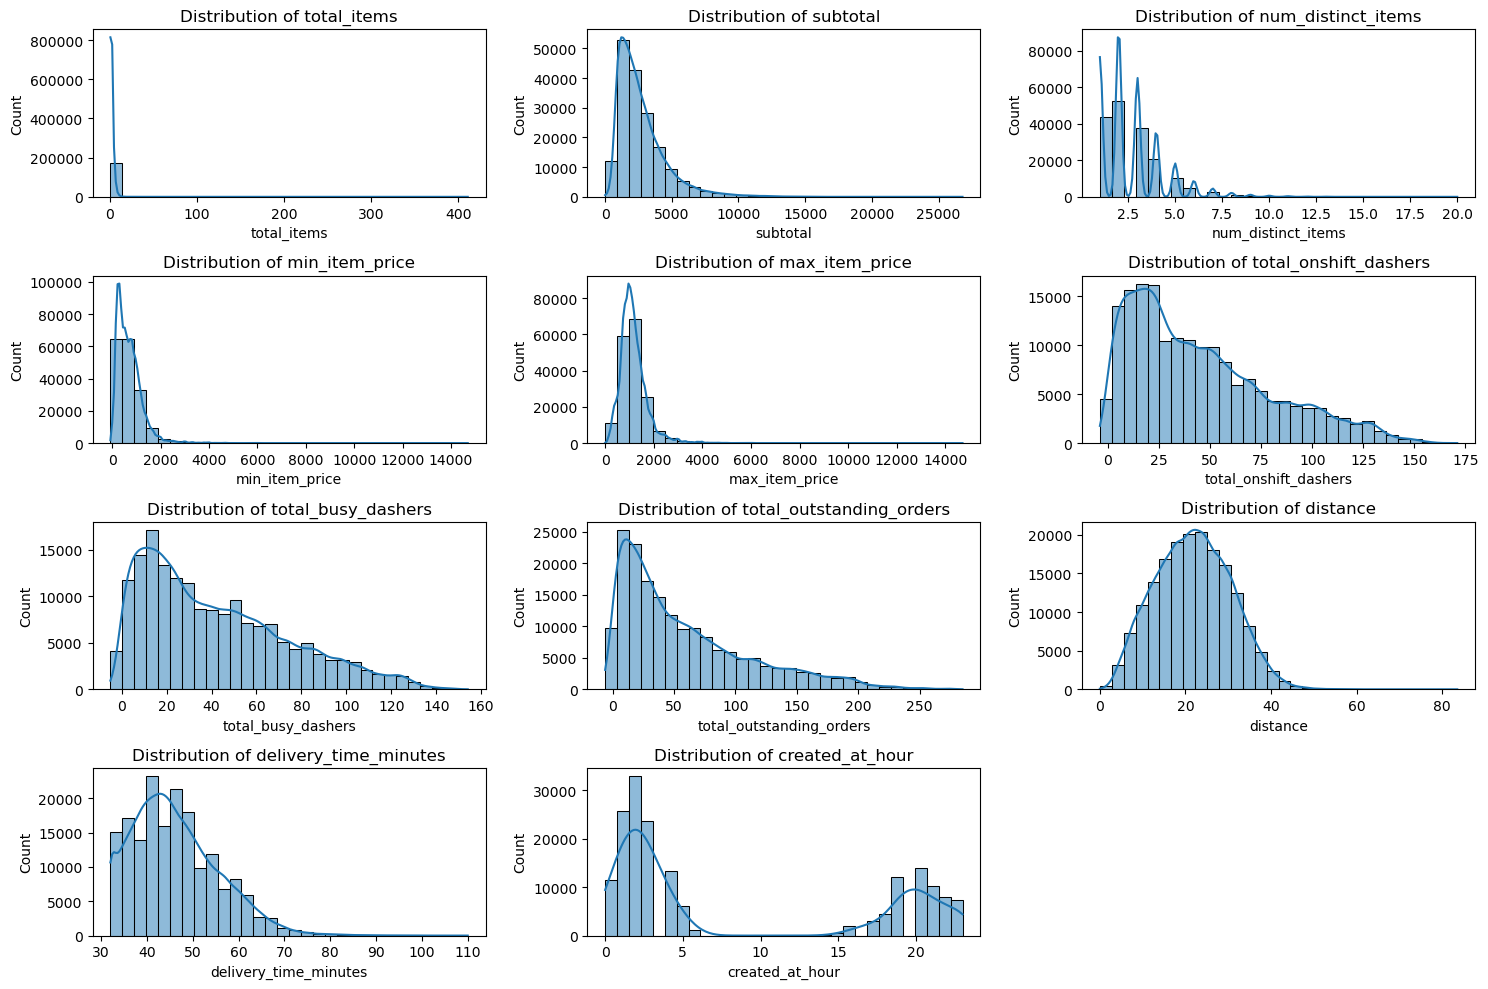

In [11]:
# Plot distributions for all numerical columns

plt.figure(figsize=(15, 10))

for i, column in enumerate(numerical_columns, 1):
    plt.subplot(4, 3, i)
    sns.histplot(df[column], bins=30, kde=True)
    plt.title(f"Distribution of {column}")

plt.tight_layout()
plt.show()

##### **3.1.2** <font color = red>[2 marks]</font> <br>
Check the distribution of categorical features

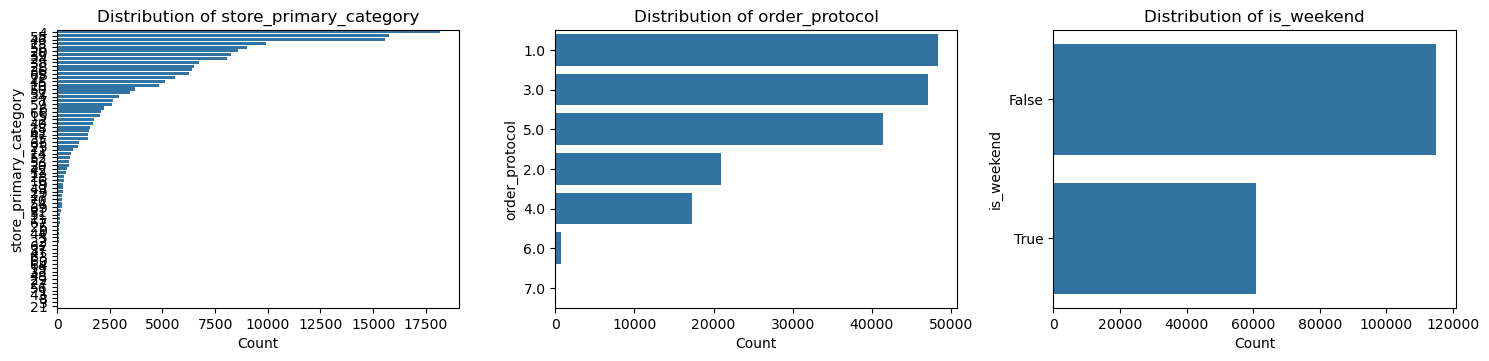

In [12]:
# Distribution of categorical columns

plt.figure(figsize=(15,10))

for i, column in enumerate(categorical_columns, 1):
    plt.subplot(3, 3, i)
    sns.countplot(y=df[column], order=df[column].value_counts().index)
    plt.title(f"Distribution of {column}")
    plt.xlabel('Count')
    plt.ylabel(column)

plt.tight_layout()
plt.show()

##### **3.1.3** <font color = red>[2 mark]</font> <br>
Visualise the distribution of the target variable to understand its spread and any skewness

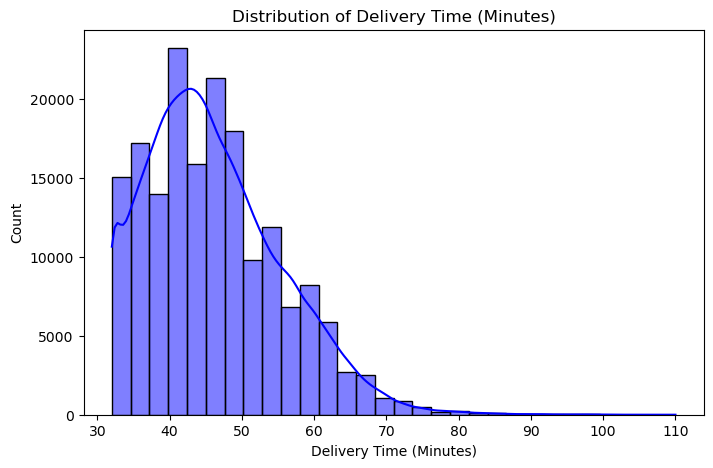

In [13]:
# Distribution of time_taken

plt.figure(figsize=(8, 5))
sns.histplot(df['delivery_time_minutes'], bins=30, kde=True, color='blue')
plt.title("Distribution of Delivery Time (Minutes)")
plt.xlabel("Delivery Time (Minutes)")
plt.ylabel("Count")
plt.show()

#### **3.2 Relationships Between Features** <font color = red>[3 marks]</font> <br>

##### **3.2.1** <font color = red>[3 marks]</font> <br>
Scatter plots for important numerical and categorical features to observe how they relate to `time_taken`

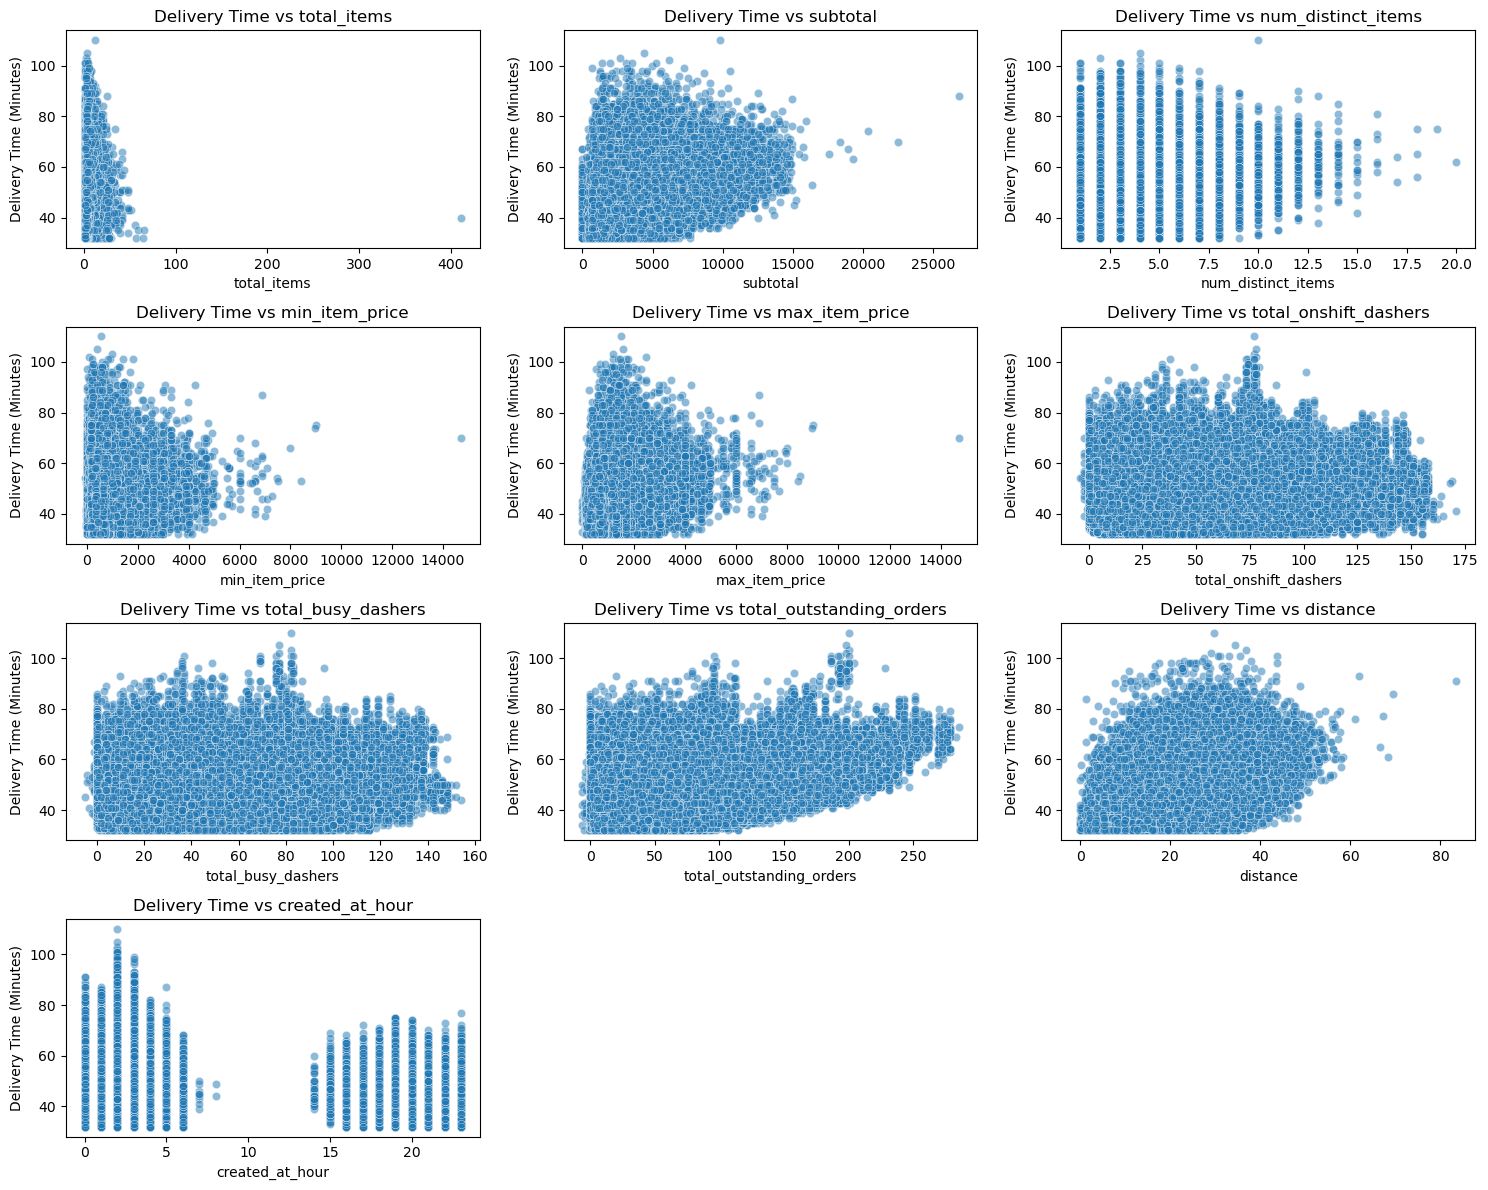

In [14]:
# Scatter plot to visualise the relationship between time_taken and other features

# Identify numerical features (excluding the target variable)
numerical_cols = df.select_dtypes(include=['int32', 'int64', 'float64']).columns.tolist()
numerical_cols.remove('delivery_time_minutes')  # Remove target variable

# Create scatter plots
plt.figure(figsize=(15, 12))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(4, 3, i)  # Adjust grid size based on the number of features
    sns.scatterplot(x=df[col], y=df['delivery_time_minutes'], alpha=0.5)
    plt.title(f"Delivery Time vs {col}")
    plt.xlabel(col)
    plt.ylabel("Delivery Time (Minutes)")

plt.tight_layout()
plt.show()

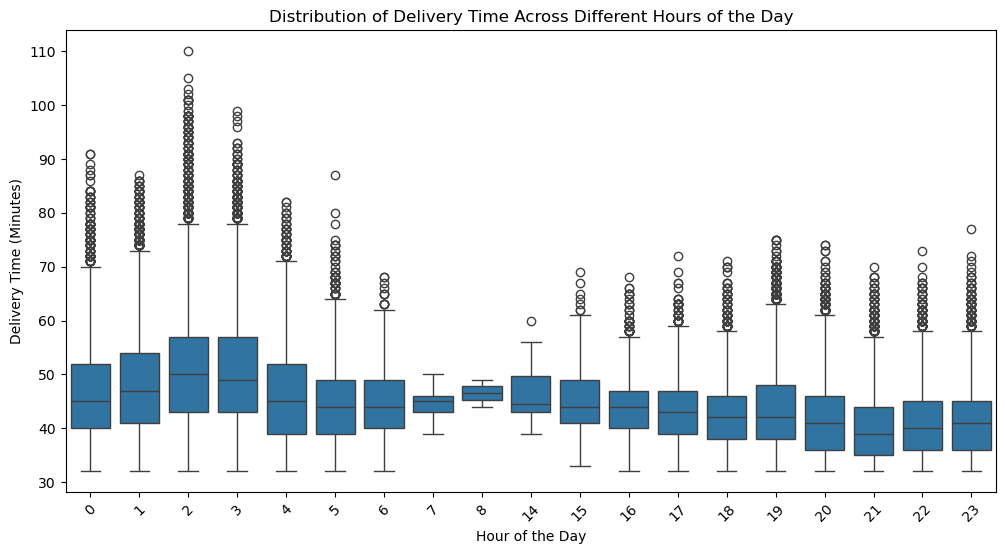

In [15]:
# Show the distribution of time_taken for different hours

plt.figure(figsize=(12, 6))
sns.boxplot(x=df['created_at_hour'], y=df['delivery_time_minutes'])
plt.title("Distribution of Delivery Time Across Different Hours of the Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Delivery Time (Minutes)")
plt.xticks(rotation=45)
plt.show()

#### **3.3 Correlation Analysis** <font color = red>[5 marks]</font> <br>
Check correlations between numerical features to identify which variables are strongly related to `time_taken`

##### **3.3.1** <font color = red>[3 marks]</font> <br>
Plot a heatmap to display correlations

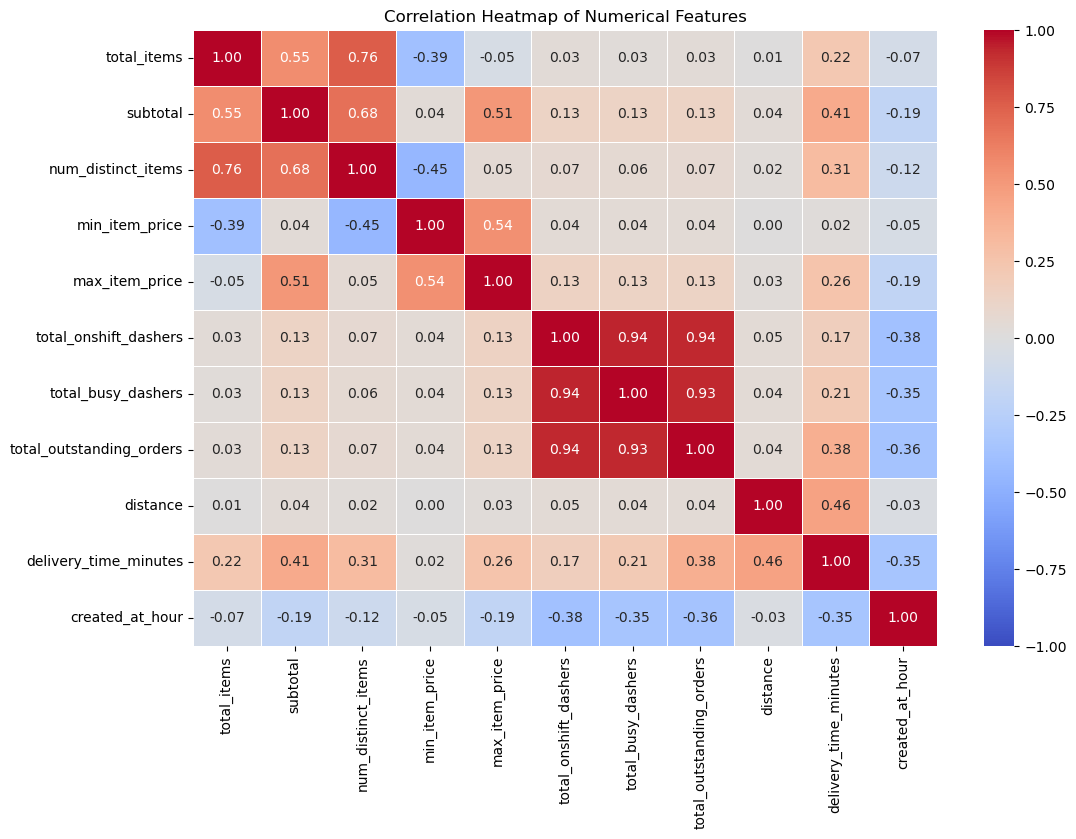

In [16]:
# Plot the heatmap of the correlation matrix

corr_matrix = numerical_columns.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, vmin=-1, vmax=1)

# Title
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

##### **3.3.2** <font color = red>[2 marks]</font> <br>
Drop the columns with weak correlations with the target variable

In [17]:
# Drop 3-5 weakly correlated columns from training dataset

correlations = numerical_columns.corr()['delivery_time_minutes'].abs().sort_values()

weak_features = correlations.head(3).index.tolist()
print("Weak features: ", weak_features)

# Drop weak features from training and testing sets
x_train = x_train.drop(columns=weak_features)
x_test = x_test.drop(columns=weak_features)

# Print the updated shape
print("Updated X_train shape:", x_train.shape)
print("Updated X_test shape:", x_test.shape)

Weak features:  ['min_item_price', 'total_onshift_dashers', 'total_busy_dashers']
Updated X_train shape: (140621, 11)
Updated X_test shape: (35156, 11)


#### **3.4 Handling the Outliers** <font color = red>[5 marks]</font> <br>



##### **3.4.1** <font color = red>[2 marks]</font> <br>
Visualise potential outliers for the target variable and other numerical features using boxplots

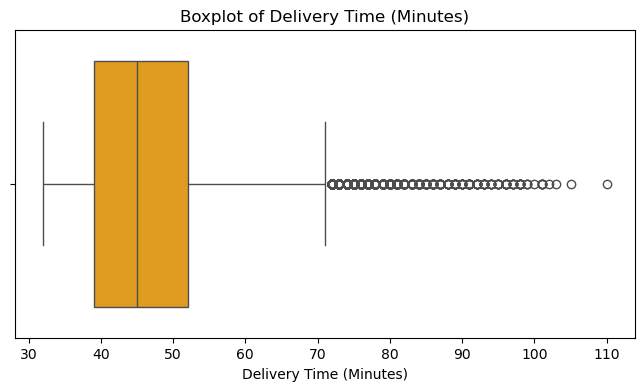

In [18]:
# Boxplot for time_taken

plt.figure(figsize=(8, 4))
sns.boxplot(x=df['delivery_time_minutes'], color='orange')
plt.title("Boxplot of Delivery Time (Minutes)")
plt.xlabel("Delivery Time (Minutes)")
plt.show()

##### **3.4.2** <font color = red>[3 marks]</font> <br>
Handle outliers present in all columns

In [19]:
# Handle outliers

def remove_outliers(df):
    for col in df.columns:
        Q1 = df[col].quantile(0.25)  # 25th percentile
        Q3 = df[col].quantile(0.75)  # 75th percentile
        IQR = Q3 - Q1  # Interquartile Range
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filter out values beyond the bounds
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    
    return df

numerical_columns_cleaned = remove_outliers(numerical_columns)

# Print data shape before and after outlier removal
print(f"Original dataset shape: {numerical_columns.shape}")
print(f"Cleaned dataset shape: {numerical_columns_cleaned.shape}")

Original dataset shape: (175777, 11)
Cleaned dataset shape: (144987, 11)


## **4. Exploratory Data Analysis on Validation Data** <font color = red>[optional]</font> <br>
Optionally, perform EDA on test data to see if the distribution match with the training data

In [20]:
# Define numerical and categorical columns for easy EDA and data manipulation



#### **4.1 Feature Distributions**


##### **4.1.1**
Plot distributions for numerical columns in the validation set to understand their spread and any skewness

In [21]:
# Plot distributions for all numerical columns



##### **4.1.2**
Check the distribution of categorical features

In [22]:
# Distribution of categorical columns



##### **4.1.3**
Visualise the distribution of the target variable to understand its spread and any skewness

In [23]:
# Distribution of time_taken



#### **4.2 Relationships Between Features**
Scatter plots for numerical features to observe how they relate to each other, especially to `time_taken`

In [24]:
# Scatter plot to visualise the relationship between time_taken and other features



#### **4.3** Drop the columns with weak correlations with the target variable

In [25]:
# Drop the weakly correlated columns from training dataset



## **5. Model Building** <font color = red>[15 marks]</font> <br>

#### **Import Necessary Libraries**

In [26]:
# Import libraries
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#### **5.1 Feature Scaling** <font color = red>[3 marks]</font> <br>

In [27]:
# First, remove weak features and target variable from cleaned data
numerical_columns_cleaned = numerical_columns_cleaned.drop(columns=weak_features)
numerical_columns_cleaned = numerical_columns_cleaned.drop(columns=['delivery_time_minutes'])

# Apply scaling to the numerical columns
standardScaler = StandardScaler()
x_train_scaled = standardScaler.fit_transform(x_train[numerical_columns_cleaned.columns])
x_test_scaled = standardScaler.transform(x_test[numerical_columns_cleaned.columns])

Note that linear regression is agnostic to feature scaling. However, with feature scaling, we get the coefficients to be somewhat on the same scale so that it becomes easier to compare them.

#### **5.2 Build a linear regression model** <font color = red>[5 marks]</font> <br>

You can choose from the libraries *statsmodels* and *scikit-learn* to build the model.

In [28]:
# Create/Initialise the model

model = LinearRegression()

In [29]:
# Train the model using the training data

model.fit(x_train_scaled, y_train)

LinearRegression()

In [30]:
# Make predictions

y_predictions = model.predict(x_test_scaled)

In [31]:
# Find results for evaluation metrics

mae = mean_absolute_error(y_test, y_predictions)
mse = mean_squared_error(y_test, y_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_predictions)

# Print evaluation results
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

Mean Absolute Error (MAE): 5.12
Mean Squared Error (MSE): 43.62
Root Mean Squared Error (RMSE): 6.60
R² Score: 0.5016


Note that we have 12 (depending on how you select features) training features. However, not all of them would be useful. Let's say we want to take the most relevant 8 features.

We will use Recursive Feature Elimination (RFE) here.

For this, you can look at the coefficients / p-values of features from the model summary and perform feature elimination, or you can use the RFE module provided with *scikit-learn*.

#### **5.3 Build the model and fit RFE to select the most important features** <font color = red>[7 marks]</font> <br>

For RFE, we will start with all features and use
the RFE method to recursively reduce the number of features one-by-one.

After analysing the results of these iterations, we select the one that has a good balance between performance and number of features.

In [32]:
# Loop through the number of features and test the model

from sklearn.feature_selection import RFE

model = LinearRegression()
rfe = RFE(model, n_features_to_select=8)

x_train_rfe = rfe.fit_transform(x_train_scaled, y_train)
x_test_rfe = rfe.transform(x_test_scaled)

selected_features = x_train[numerical_columns_cleaned.columns].columns[rfe.support_]
print("Selected Features:", selected_features.tolist())

Selected Features: ['total_items', 'subtotal', 'num_distinct_items', 'max_item_price', 'total_outstanding_orders', 'distance', 'created_at_hour']


c:\Tools\Anaconda\Lib\site-packages\sklearn\feature_selection\_rfe.py:291: UserWarning: Found n_features_to_select=8 > n_features=7. There will be no feature selection and all features will be kept.
  warnings.warn(


In [33]:
# Build the final model with selected number of features

model.fit(x_train_rfe, y_train)
y_predictions_rfe = model.predict(x_test_rfe)

mae_rfe = mean_absolute_error(y_test, y_predictions_rfe)
mse_rfe = mean_squared_error(y_test, y_predictions_rfe)
rmse_rfe = np.sqrt(mse_rfe)
r2_rfe = r2_score(y_test, y_predictions_rfe)

# Print evaluation results
print(f"Mean Absolute Error (MAE): {mae_rfe:.2f}")
print(f"Mean Squared Error (MSE): {mse_rfe:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_rfe:.2f}")
print(f"R² Score: {r2_rfe:.4f}")


Mean Absolute Error (MAE): 5.12
Mean Squared Error (MSE): 43.62
Root Mean Squared Error (RMSE): 6.60
R² Score: 0.5016


## **6. Results and Inference** <font color = red>[5 marks]</font> <br>

#### **6.1 Perform Residual Analysis** <font color = red>[3 marks]</font> <br>

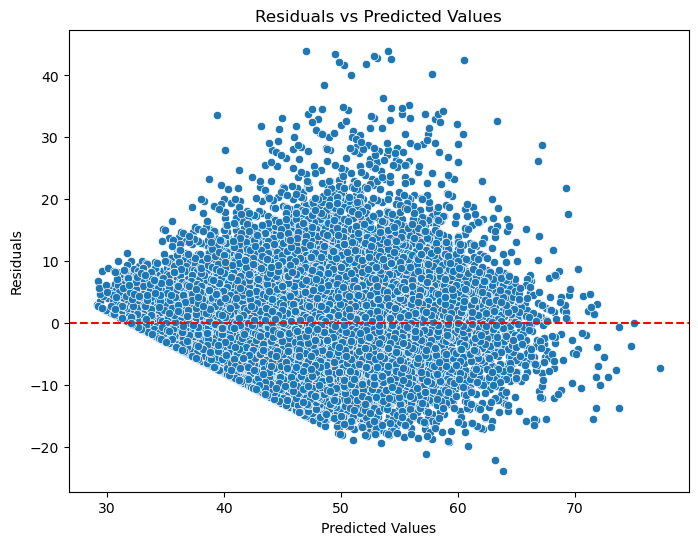

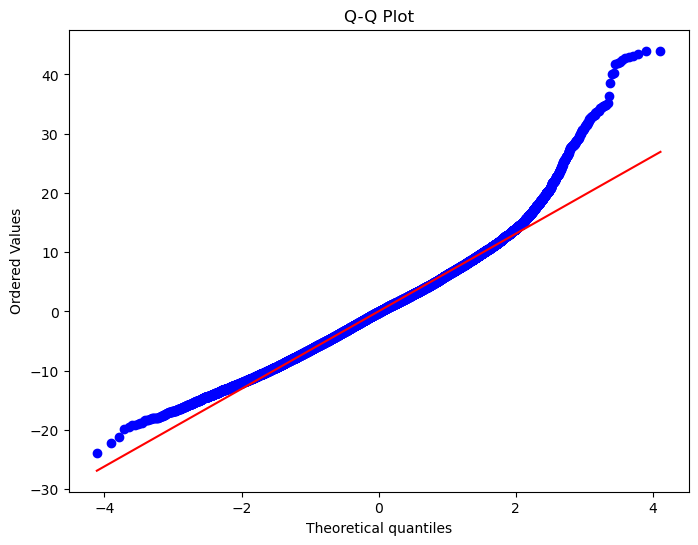

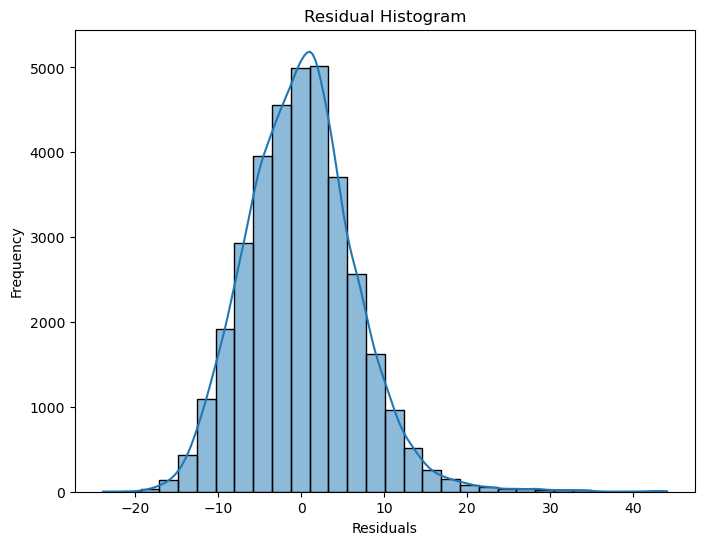

In [34]:
import scipy.stats as stats

# Perform residual analysis using plots like residuals vs predicted values, Q-Q plot and residual histogram
# Calculate residuals
residuals = y_test - y_predictions_rfe

# Residuals vs Predicted Values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_predictions_rfe, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

# Q-Q Plot
plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()

# Residual Histogram
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.title('Residual Histogram')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

[Your inferences here:]



#### **6.2 Perform Coefficient Analysis** <font color = red>[2 marks]</font> <br>

Perform coefficient analysis to find how changes in features affect the target.
Also, the features were scaled, so interpret the scaled and unscaled coefficients to understand the impact of feature changes on delivery time.


In [35]:
# Coefficient analysis

coefficients = pd.DataFrame(model.coef_, x_train[numerical_columns_cleaned.columns].columns, columns=['Coefficient'])
coefficients = coefficients.sort_values(by='Coefficient', ascending=False)
coefficients

,Coefficient
distance,4.030336
total_outstanding_orders,2.429045
subtotal,2.214576
num_distinct_items,0.990438
max_item_price,0.441246
total_items,-0.084359
created_at_hour,-1.621229


In [36]:
# Compare the scaled vs unscaled features used in the final model

model_scaled = stm.OLS(y_train, stm.add_constant(x_train_scaled)).fit()
coefficients_scaled = model_scaled.params[1:]
coefficients_original = coefficients_scaled/standardScaler.scale_

coefficients_comparison = pd.DataFrame({
    'Feature: ': x_train[numerical_columns_cleaned.columns].columns,
    'Coefficient (Scaled)': coefficients_scaled.values,
    'Coefficient (Original)': coefficients_original.values
})
coefficients_comparison

,Feature:,Coefficient (Scaled),Coefficient (Original)
0,total_items,-0.084359,-0.030933
1,subtotal,2.214576,0.001210
2,num_distinct_items,0.990438,0.609119
3,max_item_price,0.441246,0.000788
4,total_outstanding_orders,2.429045,0.046028
5,distance,4.030336,0.460551
6,created_at_hour,-1.621229,-0.186836


Additionally, we can analyse the effect of a unit change in a feature. In other words, because we have scaled the features, a unit change in the features will not translate directly to the model. Use scaled and unscaled coefficients to find how will a unit change in a feature affect the target.

In [41]:
# Analyze the effect of a unit change in a feature, say 'total_items'

feature_index = x_train[numerical_columns_cleaned.columns].columns.get_loc('total_items')

scaled_impact = coefficients_scaled.iloc[feature_index]
original_impact = coefficients_original.iloc[feature_index]

print("Effect of a unit change in total_items:")
print(f"\nScaled impact: {scaled_impact:.4f}")
print(f"\nUnscaled impact: {original_impact:.4f}")

Effect of a unit change in total_items:

Scaled impact: -0.0844

Unscaled impact: -0.0309


Note:
The coefficients on the original scale might differ greatly in magnitude from the scaled coefficients, but they both describe the same relationships between variables.

Interpretation is key: Focus on the direction and magnitude of the coefficients on the original scale to understand the impact of each variable on the response variable in the original units.

Include conclusions in your report document.

## Subjective Questions <font color = red>[20 marks]</font>

Answer the following questions only in the notebook. Include the visualisations/methodologies/insights/outcomes from all the above steps in your report.

#### Subjective Questions based on Assignment

##### **Question 1.** <font color = red>[2 marks]</font> <br>

Are there any categorical variables in the data? From your analysis of the categorical variables from the dataset, what could you infer about their effect on the dependent variable?

**Answer:**
>



---



##### **Question 2.** <font color = red>[1 marks]</font> <br>
What does `test_size = 0.2` refer to during splitting the data into training and test sets?

**Answer:**
> This means that 20% of the dataset is used for the testing, and 80% is used for training



---



##### **Question 3.** <font color = red>[1 marks]</font> <br>
Looking at the heatmap, which one has the highest correlation with the target variable?  

**Answer:**
> `distance` has the highest correlation with the target variable, `delivery_time_minutes`



---



##### **Question 4.** <font color = red>[2 marks]</font> <br>
What was your approach to detect the outliers? How did you address them?

**Answer:**

> Outliers were identified and addressed using the IQR (Inter-Quartile Range) method. All values below `Q1 - 1.5 * IQR` and above `Q3 + 1.5 * IQR` are considered as outliers, and removed accordingly.



---



##### **Question 5.** <font color = red>[2 marks]</font> <br>
Based on the final model, which are the top 3 features significantly affecting the delivery time?

**Answer:**
> `distance`, `total_outstanding_orders` and `subtotal`



---



#### General Subjective Questions

##### **Question 6.** <font color = red>[3 marks]</font> <br>
Explain the linear regression algorithm in detail

**Answer:**
> It's a supervised learning algorithm used to predict a continuous target variable based on various input features. The algorithm assumes a linear relationship between the features and target variables.




---



##### **Question 7.** <font color = red>[2 marks]</font> <br>
Explain the difference between simple linear regression and multiple linear regression

**Answer:**
> Simple Linear Regression makes use of only one feature/variable in order to make predictions about the target variable, while Multiple Linear Regression makes use of two or more features/variables



---



##### **Question 8.** <font color = red>[2 marks]</font> <br>
What is the role of the cost function in linear regression, and how is it minimized?

**Answer:**
> The cost function measures how far off the model's predictions are from the actual values. It can be minimized using Gradient Descent or Normal Equation.




---



##### **Question 9.** <font color = red>[2 marks]</font> <br>
Explain the difference between overfitting and underfitting.



**Answer:**

> Overfitting: When the model learns too much from the training data, essentially capturning noise instead of actual patterns.

> Underfitting: When the model is too simple that it fails to capture any underlying patterns.



---



##### **Question 10.** <font color = red>[3 marks]</font> <br>
How do residual plots help in diagnosing a linear regression model?

**Answer:**

> A residual plot helps identify if the model is appropriate by visualizing whether the residuals are randomly distributed around 0. If the residuals have a trend, then it may suggest important variables are missing.